<a id="index"></a>
# SENTIMENT FEATURES - EXPLORATORY ANALYSIS & BENCHMARKS

-----------------------------------------------------------------
**[1. Load Data & Libraries](#load_data)**
<br>
**[2. User Ratings](#ratings)**
<br>
**[3. Sentiment](#sentiment)**
<br> &nbsp;&nbsp;&nbsp; - [Amazon Comprehend Sentiment](#aws)
<br> &nbsp;&nbsp;&nbsp; - [Neutral Reviews?](#neutral)
<br> &nbsp;&nbsp;&nbsp; - [Relabel Neutral Labels](#relabel)
<br> &nbsp;&nbsp;&nbsp; - [VaderSentiment](#vader)
<br> &nbsp;&nbsp;&nbsp; - [TextBlob](#textblob)
<br>
**[4. Benchmark Predictions](#benchmark)**
<br> &nbsp;&nbsp;&nbsp; - [Amazon Comprehend Benchmark](#aws_bench)
<br> &nbsp;&nbsp;&nbsp; - [Vadar & TextBlob Benchmark](#vadar_tb_bench)
<br> &nbsp;&nbsp;&nbsp; - [All Sentiment Scores Benchmark](#all_sent_bench)
<br> &nbsp;&nbsp;&nbsp; - [All Features Benchmark](#all_features_bench)
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - [Text Features - Descriptive Stats](#features)
<br>
**[5. Split Dataset](#split)**
<br> &nbsp;&nbsp;&nbsp; - [Train, Validation, Test Sets](#train)
<br> &nbsp;&nbsp;&nbsp; - [Eyeball Error Analysis Set](#eyeball)
<br> &nbsp;&nbsp;&nbsp; - [Noisy Labels](#noisy)
<br> &nbsp;&nbsp;&nbsp; - [How much error is unavoidable/ optimal?](#optimal)
<br>
**[6. Resampling Pipelines](#resampling)**
<br> &nbsp;&nbsp;&nbsp; - [Decision Trees](#dt)
<br> &nbsp;&nbsp;&nbsp; - [Random Forest](#rf)
<br> &nbsp;&nbsp;&nbsp; - [Logistic Regression](#lr)
<br> &nbsp;&nbsp;&nbsp; - [K-Nearest Neighbors](#knn)
<br> &nbsp;&nbsp;&nbsp; - [AdaBoost](#ada)
<br> &nbsp;&nbsp;&nbsp; - [XGBoost](#xgb)
<br> &nbsp;&nbsp;&nbsp; - [XGBoost Weighted](#xgb_w)
<br>
**[7. Feature Importance](#importance)**


<a id="load_data"></a>
# Load Data & Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
%matplotlib inline
from libraries import *

np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

english_cat = pd.read_json('eng_labeled_processed.json', orient='columns')
english_cat.head()

,review_id,category_pos,category_pos_names,category_neg,category_neg_names,pos_count,neg_count,sentiment,positive,negative,...,aws_sent,clean_text,raw_tokens,lemmed_tokens,tokens_wsw,tokens_wesw,tokens_wesw_stem,word_count,unique_words,char_count
0,41645,"[628, 617, 661, 648, 643]","Taste, Food, Sushi, Waitron, Service","[653, 649]","Waiting Times, Service",5,2,2,1,1,...,POSITIVE,we had a lovely sushi meal at jd s with some o...,"[we, had, a, lovely, sushi, meal, at, jd, s, w...","[we, have, a, lovely, sushi, meal, at, jd, s, ...","[lovely, sushi, meal, jd, best, sushi, long, t...","[lovely, sushi, meal, jd, best, sushi, long, t...","[love, sushi, meal, jd, best, sushi, long, tim...",85,63,422
1,52380,"[343, 313, 321, 1307, 812]","Service, Food, Steaks, Poultry, Sides",,None,5,0,1,1,0,...,POSITIVE,something has changed staff is very friendly s...,"[something, has, changed, staff, is, very, fri...","[something, have, change, staff, be, very, fri...","[change, staff, friendly, spur, perfect, meals...","[change, staff, friendly, spur, perfect, meals...","[chang, staff, friend, spur, perfect, meal, st...",23,21,139
2,54468,,None,[344],Service,0,1,0,0,1,...,NEUTRAL,two years on service still horid,"[two, years, on, service, still, horid]","[two, years, on, service, still, horid]","[years, service, horid]","[years, service, horid]","[year, servic, horid]",6,6,33
3,54721,"[343, 313, 349, 345]","Service, Food, Manager, Waitron",,None,4,0,1,1,0,...,POSITIVE,very good food and friendly manager owner and ...,"[very, good, food, and, friendly, manager, own...","[very, good, food, and, friendly, manager, own...","[food, friendly, manager, owner, staff, best, ...","[food, friendly, manager, owner, staff, best, ...","[food, friend, manag, owner, staff, best, town]",13,12,69
4,55999,"[681, 679]","Burgers, Food","[715, 711, 671, 669]","Waiting Times, Service, Facilities, Atmosphere",2,4,2,1,1,...,POSITIVE,food great good vegetarian burgers pretty good...,"[food, great, good, vegetarian, burgers, prett...","[food, great, good, vegetarian, burgers, prett...","[food, great, vegetarian, burgers, pretty, val...","[food, great, vegetarian, burgers, pretty, val...","[food, great, vegetarian, burger, pretti, valu...",23,22,153


<a id="ratings"></a>
# User Ratings 
[Return to Index](#index)

In [6]:
# Only 35 reviews had ratings of 0. Since 1 star is the minimum rating 
# allowed on multiple platforms, these reviews will be removed as outliers. 
english_cat.loc[english_cat.rating == 0].head()

,review_id,category_pos,category_pos_names,category_neg,category_neg_names,pos_count,neg_count,sentiment,positive,negative,...,aws_sent,clean_text,raw_tokens,lemmed_tokens,tokens_wsw,tokens_wesw,tokens_wesw_stem,word_count,unique_words,char_count
155769,1704295,,None,"[12495, 12510]","App, Voucher missing",0,2,0,0,1,...,NEGATIVE,customer did not receive her birthday voucher ...,"[customer, did, not, receive, her, birthday, v...","[customer, do, not, receive, her, birthday, vo...","[customer, receive, birthday, voucher, date, g...","[customer, not, receive, birthday, voucher, no...","[custom, not, receiv, birthday, voucher, no, d...",24,19,138
155832,1704895,,None,"[12495, 12698]","App, App Service",0,2,0,0,1,...,NEGATIVE,i am so disappointed that the old rewards we h...,"[i, am, so, disappointed, that, the, old, rewa...","[i, be, so, disappoint, that, the, old, reward...","[disappoint, old, reward, carry, new, app]","[disappoint, old, reward, not, carry, new, app]","[disappoint, old, reward, not, carri, new, app]",18,17,86
155836,1704925,,None,"[12495, 12698]","App, App Service",0,2,0,0,1,...,NEUTRAL,please transfer my points to my new app,"[please, transfer, my, points, to, my, new, app]","[please, transfer, my, point, to, my, new, app]","[transfer, point, new, app]","[transfer, point, new, app]","[transfer, point, new, app]",8,7,40
155841,1704963,,None,"[12495, 12698]","App, App Service",0,2,0,0,1,...,NEGATIVE,i was told today on purchasing a smoothie that...,"[i, was, told, today, on, purchasing, a, smoot...","[i, be, tell, today, on, purchase, a, smoothie...","[tell, today, purchase, smoothie, app, defunct...","[tell, today, purchase, smoothie, app, defunct...","[tell, today, purchas, smoothi, app, defunct, ...",29,23,144
155865,1705261,,None,"[12495, 12698]","App, App Service",0,2,0,0,1,...,NEUTRAL,has the kuaui app changed do i lose all my old...,"[has, the, kuaui, app, changed, do, i, lose, a...","[have, the, kuaui, app, change, do, i, lose, a...","[kuaui, app, change, lose, old, stickers]","[kuaui, app, change, lose, old, stickers]","[kuaui, app, chang, lose, old, sticker]",12,12,56


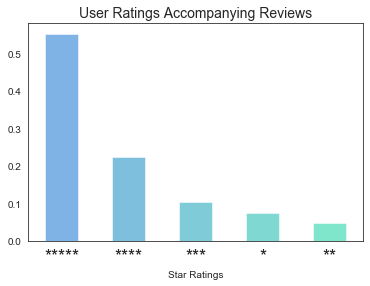

In [7]:
# User ratings are predominantly positive
zero_ratings = english_cat.review_id[english_cat.rating == 0]

english_cat = english_cat[~english_cat.review_id.isin(zero_ratings)]

color = cm.winter(np.linspace(.4,.8, 5))
english_cat.rating.value_counts(normalize=True)\
           .plot(kind='bar', color=color, alpha=0.5)
plt.xticks(np.arange(5), labels = ['*****', '****', '***', '*', '**'], 
           rotation=0, fontsize= 18)
plt.xlabel('Star Ratings')
plt.title('User Ratings Accompanying Reviews', fontsize=14);

-------------------------------------------
**Sentiment in text is poorly predicted by the ratings.**

This is because users often include a positive element in a negative review, or a negative element in a positive review. Ratings, or overall satisfaction, are not synonymous with the sentiment in the text. Ratings are also sometimes incorrectly allocated by the user.

However, it is critical for an automated response system to accurately gauge how negative or positive the text of a review is, as human-level responses would take this into consideration. It is not enough to respond to the rating. 

Normalized confusion matrix


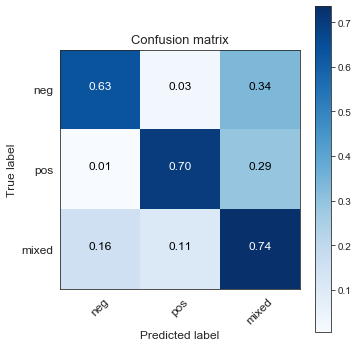

In [8]:
rating_preds = [0 if n < 3 else 2 if 3 <= n <= 4 else 1 for n in english_cat.rating]
cm = confusion_matrix(english_cat.sentiment, rating_preds)
plot_confusion_matrix(cm, ['neg', 'pos', 'mixed'], normalize=True)

-----------------------------------------------------------
<a id="sentiment"></a>
# Sentiment Libraries
[Return to Index](#index)

Various unsupervised sentiment solutions were tested for benchmarking (i.e., to see whether they outperform our pretrained-bert model), and also to test their value as input features with the labeled data (i.e., as a supervised solution). 
<a id="aws"></a>
## Amazon Comprehend

Amazon Comprehend scores represent "...the likelihood that the sentiment was correctly detected". Thus, the score does not represent the magnitude of affect in the text, but the estimated confidence of the model in it's predictions.

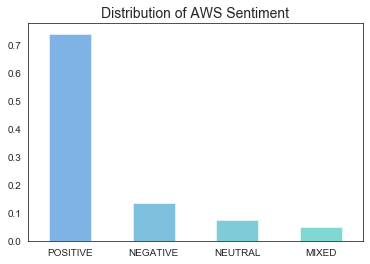

In [9]:
english_cat.aws_sent.value_counts(normalize=True)\
                    .plot(kind='bar', color=color, alpha=0.5)
plt.xticks(rotation=0)
plt.title('Distribution of AWS Sentiment', fontsize=14);

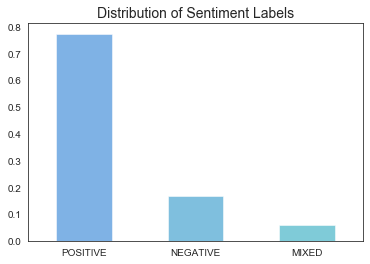

In [10]:
english_cat.sentiment.value_counts(normalize=True)\
                     .plot(kind='bar', color=color, alpha=0.5)
plt.xticks(ticks = np.arange(3), 
           labels = ['POSITIVE', 'NEGATIVE', 'MIXED'], rotation=0)
plt.title('Distribution of Sentiment Labels', fontsize=14);

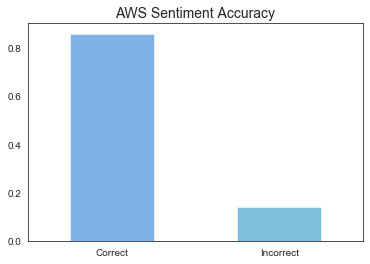

In [12]:
def label_correct (row):
    """Return binary value (True = 1, False = 0) for comparison 
    between aws sentiment scores and sentiment labels. A mismatch or 
    neutral aws label would result in 0."""
    
    if row['sentiment'] == 1.0 and row['aws_sent'] == 'POSITIVE':
        return 1
    if row['sentiment'] == 0.0 and row['aws_sent'] == 'NEGATIVE':
        return 1
    if row['sentiment'] == 2.0 and row['aws_sent'] == 'MIXED':
        return 1
    return 0

# create preds labels from Comprehend sentiment labels
english_cat['aws_sent'] = english_cat['aws_sent'].astype('category')

english_cat['aws_preds'] = english_cat.apply(lambda row: label_correct(row), axis=1)

# The aws text labels were assigned numeric values conisistent with 
# the sentiment labels in the dataset
english_cat['aws_numeric_sent'] = english_cat['aws_sent'].cat.rename_categories([2, 0, 3, 1])

# Comprehend has around 85% accuracy overall. But like any imbalanced dataset, 
# there is a bias towards the majority class. 

english_cat.aws_preds.value_counts(normalize=True)\
                     .plot(kind='bar', color=color, alpha=0.5)
plt.xticks(np.arange(2), labels=['Correct', 'Incorrect'], rotation=0)
plt.title('AWS Sentiment Accuracy', fontsize=14);

Normalized confusion matrix


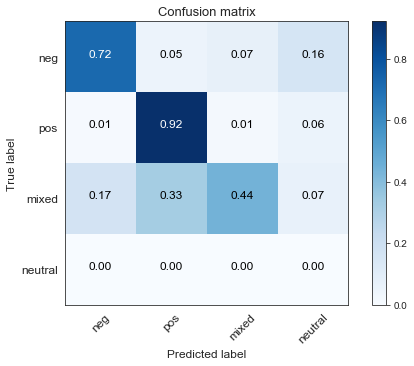

In [13]:
cm = confusion_matrix(english_cat.sentiment, english_cat.aws_numeric_sent)
plot_confusion_matrix(cm, ['neg', 'pos', 'mixed', 'neutral'], 
                      figsize = (7, 5), normalize=True)

------------------------------------------------------
The Amazon Comprehend sentiment scores were consistent with positive labels; however, negative labels were only consistent 72% of the time, and mixed labels only 44%. Also, 16% of negative reviews, 5% of positive reviews, and 7% of mixed reviews were classfied as neutral according to Amazon Comprehend.  

In [14]:
# The score represents the likelihood that the sentiment was correctly detected
# 0 - negative, 1 - positive, 2 - mixed

aws_means = english_cat.groupby('sentiment')['aws_pos','aws_neg', 'aws_neu', 'aws_mix'].mean()
aws_means

,aws_pos,aws_neg,aws_neu,aws_mix
sentiment,,,,
0,0.071526,0.656196,0.176426,0.095852
1,0.858644,0.013837,0.100351,0.027168
2,0.316459,0.185734,0.094604,0.403202


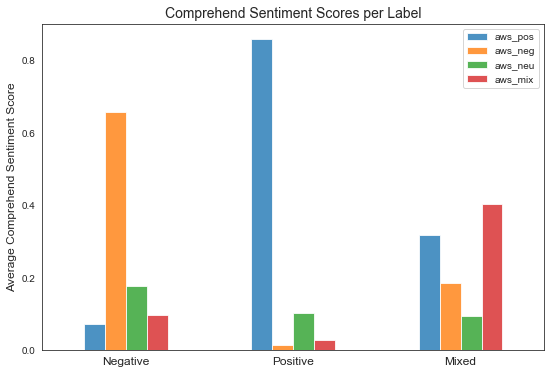

In [15]:
# While positive, negative and mixed Comprehend likelihoods were the highest
# for their respective labels, the neutral scores were distrubuted across labels,
# and highest for negatively labeled reviews. 

aws_means.plot(kind='bar', figsize=(9,6), alpha=0.8)
plt.xticks(range(3), labels=['Negative', 'Positive', 'Mixed'], fontsize=12, rotation=0)
plt.title('Comprehend Sentiment Scores per Label', fontsize=14)
plt.xlabel(None)
plt.ylabel('Average Comprehend Sentiment Score', fontsize=12);

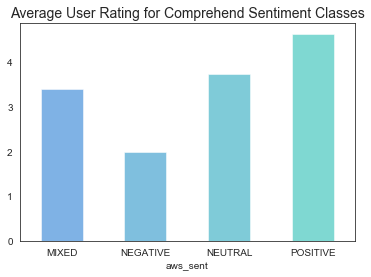

In [16]:
# The average rating for the NEUTRAL Comprehend label was 3.7 - higher 
# than the NEGATIVE and MIXED labels. 

english_cat.groupby('aws_sent')['rating'].mean()\
           .plot(kind='bar', color=color, alpha=0.5)
plt.xticks(np.arange(4), rotation=0)
plt.title('Average User Rating for Comprehend Sentiment Classes', fontsize=14);

<a id="neutral"></a>
## Neutral Reviews?

Is the neutral label appropriate for our data? It's likely that restaurant reviews are not often truly neutral. 

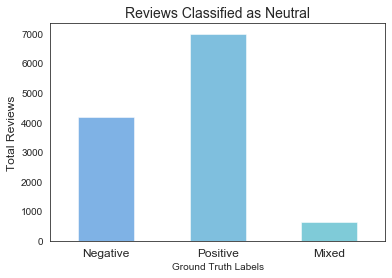

In [17]:
neutral = english_cat[english_cat.aws_sent.str.contains('NEUTRAL')]

neutral.groupby('sentiment')['review_id'].count()\
       .plot(kind='bar', color=color, alpha=0.5)
plt.xticks(range(3), labels=['Negative', 'Positive', 'Mixed'], fontsize=12, rotation=70)
plt.title('Reviews Classified as Neutral', fontsize=14)
plt.xticks(np.arange(3), rotation=0)
plt.xlabel('Ground Truth Labels')
plt.ylabel('Total Reviews', fontsize=12);

------------------------------------------
The reviews classifed as neutral were proportional for positive and mixed reviews. However, there appeared to be a bias towards negative reviews being classified as neutral - with around 25% of negative reviews receiving a neutral label.

In [18]:
# Reading through reviews with a high likelihood of being neutral,
# it is obvious that these reviews are not neutral. 

pd.set_option('display.max_colwidth', -1)
neutral.combined.loc[neutral.aws_neu > 0.9]

2         Two years on. Service still horid.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
660        For the meat eaters                                                                                                                                                                                                                                                                                                                             

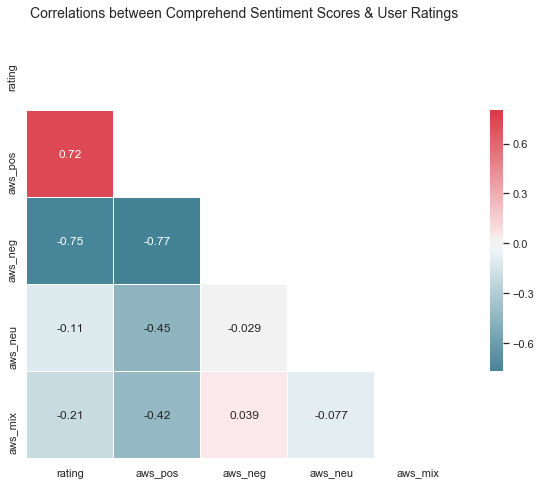

In [72]:
# There were clear correlations with positive and negative ratings and 
# Comprehend's positive and negative reviews. There is no distinct relationship
# with neutral or mixed.

corr_matrix(english_cat[['rating', 'aws_pos', 'aws_neg', 'aws_neu', 'aws_mix']])
plt.title('Correlations between Comprehend Sentiment Scores & User Ratings', fontsize=14);

<a id="relabel"></a>
## Relabel Neutral Reviews

Normalized confusion matrix


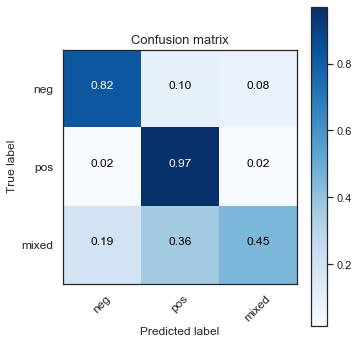

In [23]:
adjusted_aws_preds = np.argmax(english_cat[['aws_neg','aws_pos','aws_mix']].to_numpy(), axis=1)

cm = confusion_matrix(english_cat.sentiment, adjusted_aws_preds)
plot_confusion_matrix(cm, ['neg', 'pos', 'mixed'], normalize=True)

Relabeling the neutral reviews as the next most probable label results in an 11% increase in accuracy of negative reviews, a 4% increase for positive reviews, but only a 1% increase for mixed. Therefore, mixed reviews were especially likely to be classified incorrectly using Amazon Comprehend.

-----------------------------

<a id="vader"></a>
# VaderSentiment

[VADER](https://github.com/cjhutto/vaderSentiment#about-the-scoring) (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains. The scoring criteria below are directly from the github page.

About the Scoring
------------------------------
----------------------------------------
- The `compound` score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

    It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

> 1. **positive** sentiment: `compound` score >= 0.05
<br>
> 2. **neutral** sentiment: (`compound` score > -0.05) and (`compound` score < 0.05)
<br>
> 3. **negative** sentiment: `compound` score <= -0.05

- The `pos`, `neu`, and `neg` scores are ratios for proportions of text that fall in each category (so these should all add up to be 1... or close to it with float operation). These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.

[Return to Index](#index)

In [14]:
%%time
# Vadar was run on the cleaned preprocessed text - removing punctuation, urls, 
# splitting hashtags, lowercase, expanding contractions. 

analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    df = pd.Series(score)
    return df

polarity_df = english_cat['clean_text'].apply(sentiment_analyzer_scores)

english_cat['vadar_compound'] = polarity_df['compound']
english_cat['vadar_pos'] = polarity_df['pos']
english_cat['vadar_neg'] = polarity_df['neg']
english_cat['vadar_neu'] = polarity_df['neu']

Wall time: 1min 58s
Parser   : 128 ms


In [70]:
vadar_means = english_cat.groupby('sentiment')['vadar_compound',
       'vadar_pos', 'vadar_neg', 'vadar_neu'].mean()
vadar_means

,vadar_compound,vadar_pos,vadar_neg,vadar_neu
sentiment,,,,
0,-0.163325,0.074581,0.160266,0.765112
1,0.698962,0.497793,0.008301,0.493906
2,0.458891,0.244997,0.064734,0.690266


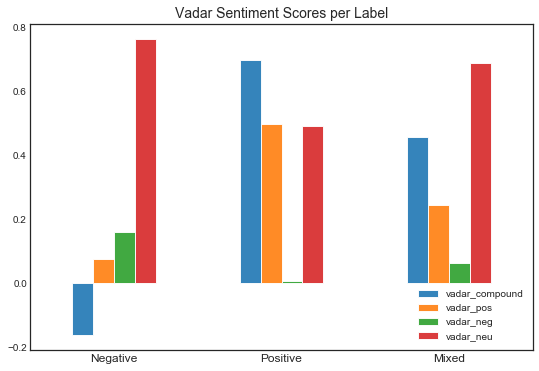

In [71]:
vadar_means.plot(kind='bar', figsize=(9,6), alpha=0.9)
plt.xticks(range(3), labels=['Negative', 'Positive', 'Mixed'], 
           fontsize=12, rotation=0)
plt.xlabel(None)
plt.title('Vadar Sentiment Scores per Label', fontsize=14);

Normalized confusion matrix


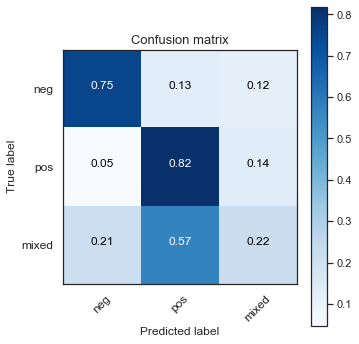

In [27]:
# despite the scoring criteria given, the thresholds below produced the best classification. 
vdpreds_compound = [0 if n < 0.15 else 2 if 0.15 < n < 0.5 else 1 for n in english_cat.vadar_compound]

cm = confusion_matrix(english_cat.sentiment, vdpreds_compound)
plot_confusion_matrix(cm, ['neg', 'pos', 'mixed'], normalize=True)

----------------------------------
It appears that the negative and positive reviews are better differentiated by the compound measure, but it was difficult to find a cut-off for the mixed reviews.

<a id="textblob"></a>
## TextBlob 

TextBlob is a Python (2 and 3) library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.

The sentiment property returns a namedtuple of the form `Sentiment(polarity, subjectivity)`. The `polarity score` is a float within the range `[-1.0, 1.0]`. The `subjectivity` is a float within the range `[0.0, 1.0]` where `0.0` is very objective and `1.0` is very subjective.

[Return to Index](#index)

In [15]:
%%time
tb_sentiment = [TextBlob(i).sentiment.polarity for i in english_cat.clean_text]

english_cat['tb_sentiment'] = tb_sentiment

Wall time: 1min 13s


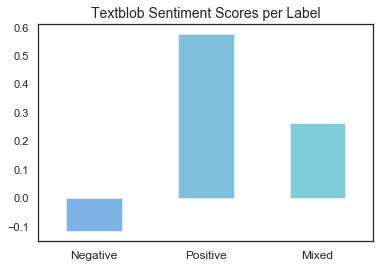

In [29]:
english_cat.groupby('sentiment')['tb_sentiment']\
           .mean().plot(kind='bar', color=color, alpha=0.5)
plt.xticks(range(3), labels=['Negative', 'Positive', 'Mixed'], 
           fontsize=12, rotation=0)
plt.xlabel(None)
plt.title('Textblob Sentiment Scores per Label', fontsize=14);

Normalized confusion matrix


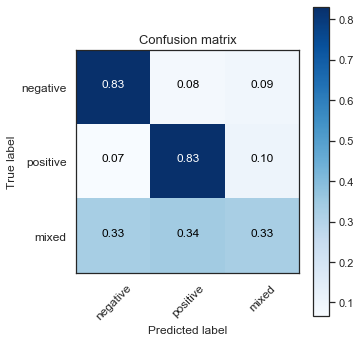

In [30]:
tbpreds = [0 if n < 0.15 else 2 if 0.15 < n < 0.35 else 1 for n in english_cat.tb_sentiment]
cm = confusion_matrix(english_cat.sentiment, tbpreds)
plot_confusion_matrix(cm, ['negative', 'positive', 'mixed'], normalize=True)

----------------------------------
Using cutoffs for the compound score resulted in decent classifications for the negative and positive classes, but very poor classification for the mixed class.

<a id="benchmark"></a>
# Benchmark Predictions
[Return to Index](#index)

Sentiment features were used as inputs for supervised learning with a linear learner (Logistic Regression). The purpose of these initial models was to benchmark performance. 
<a id="aws_bench"></a>
## Amazon Comprehend

Normalized confusion matrix


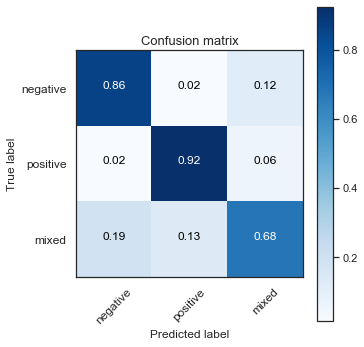

In [35]:
# aws neutral was excluded because exploration (above) 
# showed it to be unreliable, with no predictive impact. 
features = ['rating', 'aws_pos', 'aws_neg', 'aws_mix']

X_train_aws, X_val_aws, _ = get_datasets(train, val, test, 
                                         features = features,
                                         scale=True)

logreg = LogisticRegression(solver = 'newton-cg', multi_class='multinomial', 
                            class_weight='balanced')
model_aws = logreg.fit(X_train_aws, y_train)
preds_aws = model_aws.predict(X_val_aws)

cm = confusion_matrix(y_val, preds_aws)
plot_confusion_matrix(cm, ['negative', 'positive', 'mixed'], normalize=True)

---------------------------------------------------------------------
Using Comprehend's scores within a supervised classification framework significantly improves performance.

<br>
<br>

<a id="vadar_tb_bench"></a>
## Vader & Textblob

Vader and TextBlob were added together into a supervised Logistic Regression model for benchmarking.

Normalized confusion matrix


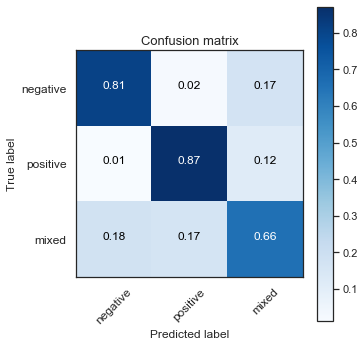

In [36]:
features = ['rating', 'vadar_compound', 'vadar_pos', 'vadar_neg', 'vadar_neu',
            'tb_sentiment']

X_train, X_val, _ = get_datasets(train, val, test, 
                                 features = features,
                                 scale=True)

logreg = LogisticRegression(solver = 'newton-cg', multi_class='multinomial', 
                            class_weight='balanced')

model = logreg.fit(X_train, y_train)
preds = model.predict(X_val)

cm = confusion_matrix(y_val, preds)
plot_confusion_matrix(cm, ['negative', 'positive', 'mixed'], normalize=True)

----------------------------------------------
Predictions were improved with supervised learning. 

<br>
<br>

<a id="all_sent_bench"></a>
## All Sentiment Scores

Normalized confusion matrix


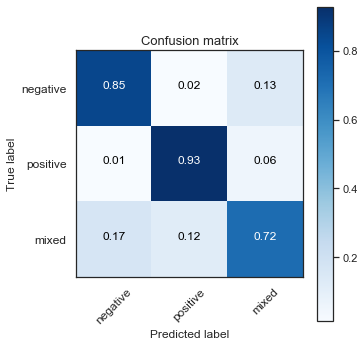

In [37]:
features = ['rating', 'vadar_compound', 'vadar_pos', 'vadar_neg', 'vadar_neu',
            'tb_sentiment', 'aws_pos', 'aws_neg', 'aws_mix']

X_train, X_val, _ = get_datasets(train, val, test, 
                                 features = features,
                                 scale=True)

logreg = LogisticRegression(solver = 'newton-cg', multi_class='multinomial', 
                            class_weight='balanced')
model = logreg.fit(X_train, y_train)
preds = model.predict(X_val)

cm = confusion_matrix(y_val, preds)
plot_confusion_matrix(cm, ['negative', 'positive', 'mixed'], normalize=True)

Using all sentiment scores together results in a 4% increase in prediction accuracy for mixed reviews.

--------------------------------------------------------
<a id="all_features_bench"></a>
## All Features

In addition to sentiment features, text features (previously preprocessed) were added to the supervised model.

<a id="features"></a>
### Text Features - Descriptive Stats

In [38]:
english_cat[['word_count', 'unique_words', 'char_count']].describe().round()

,word_count,unique_words,char_count
count,158995.0,158995.0,158995.0
mean,20.0,16.0,106.0
std,29.0,19.0,152.0
min,1.0,1.0,3.0
25%,5.0,5.0,30.0
50%,10.0,9.0,56.0
75%,23.0,20.0,124.0
max,542.0,262.0,2567.0


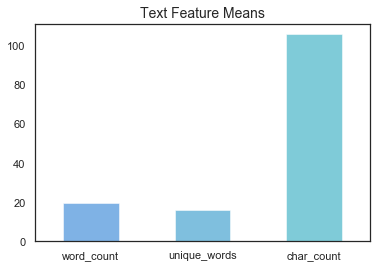

In [39]:
english_cat[['word_count', 'unique_words', 'char_count']]\
            .mean().plot(kind='bar', color=color, alpha=0.5)
plt.xticks(np.arange(3), rotation=0)
plt.title('Text Feature Means', fontsize=14);

Normalized confusion matrix


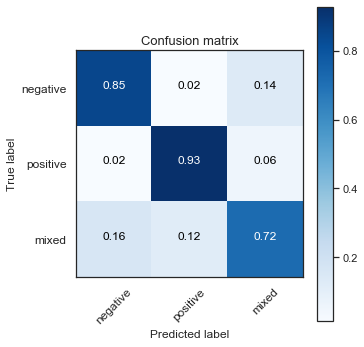

In [40]:
features = ['rating', 'vadar_compound', 'vadar_pos', 'vadar_neg', 'vadar_neu',
            'tb_sentiment', 'aws_pos', 'aws_neg', 'aws_mix', 'word_count', 
            'unique_words', 'char_count']

X_train, X_val, _ = get_datasets(train, val, test, 
                                 features = features,
                                 scale=True)

logreg = LogisticRegression(solver = 'newton-cg', multi_class='multinomial', 
                            class_weight='balanced')
model = logreg.fit(X_train, y_train)
preds = model.predict(X_val)

cm = confusion_matrix(y_val, preds)
plot_confusion_matrix(cm, ['negative', 'positive', 'mixed'], normalize=True)

Adding text features had no impact on predictive performance; at least for the linear learner. 

----------

<a id="split"></a>
# Split Dataset
The labeled data was split into `train`, `validation` and `test` sets, and saved. The same sets will be used across all frameworks and notebooks so that valid comparisons in performance can be made.  

[Return to Index](#index)

---------------------------------

<a id="train"></a>
## Train, Validation, Test

In [10]:
# Datasets were split and saved for use throughout the rest
# of the project. 
english_cat = pd.read_json('eng_labeled_processed.json', orient='columns')

# Add weights array
label_percent = english_cat.sentiment.value_counts(normalize=True)

neg_percent = label_percent[0]
pos_percent = label_percent[1]
mixed_percent = label_percent[2]

neg_weight = mixed_percent/neg_percent
pos_weight = mixed_percent/pos_percent
mixed_weight = mixed_percent/mixed_percent
    
def create_weights_array(x):
    if x == 0.0:
        return round(neg_weight, 3)
    if x == 1.0:
        return round(pos_weight, 3)
    else:
        return mixed_weight

english_cat['weights'] = english_cat.sentiment.apply(create_weights_array)

SEED = 2000

X = english_cat
y = english_cat.sentiment

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y,
                                                       stratify=y,
                                                       test_size=.1, 
                                                       random_state=SEED)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test,
                                                stratify=y_val_test,
                                                test_size=.3, 
                                                random_state=SEED)

print('Length of train set: {}'.format(len(X_train)))
print('Length of validation set: {}'.format(len(X_val)))
print('Length of test set: {}'.format(len(X_test)))

#X_train.to_json(r'.data/train.json', orient='columns')
#X_test.to_json(r'.data/test.json', orient='columns')
#X_val.to_json(r'.data/val.json', orient='columns')

#y_train.to_json(r'.data/y_train.json', orient='index')
#y_test.to_json(r'.data/y_test.json', orient='index')
#y_val.to_json(r'.data/y_val.json', orient='index')

Length of train set: 143126
Length of validation set: 11132
Length of test set: 4771


<a id="eyeball"></a>
## Eyeball Error Analysis Set

---------------------------------
The `eyeball validation set` consists of 500 samples. It is a subset of the validation set that is intended for manual inspection, to aid with:

> 1. Determining human-level performance, i.e. the optimal error rate to aim for/ unavoidable underfitting (bias).
<br>
> 2. Estimating noisy (incorrect) labels.
<br>
> 3. Intuition for classifier performance and errors (understand where/ how improvements can be made).

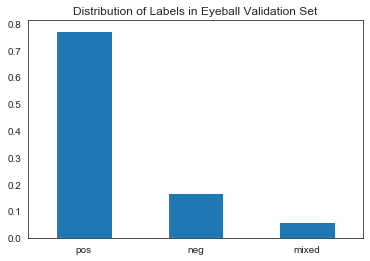

In [12]:
X_eyeval, _, _, _ = train_test_split(X_val, X_val['sentiment'],
                                    train_size=501,
                                    stratify=X_val['sentiment'],
                                    random_state=100)

X_eyeval.reset_index(inplace=True, drop=True)

X_eyeval.sentiment.map({0: 'neg', 1: 'pos', 2: 'mixed'})\
                 .value_counts(normalize=True)\
                 .plot(kind='bar')
        
plt.title('Distribution of Labels in Eyeball Validation Set')
plt.xticks(rotation=0);
X_eyeval.to_json('./data/eyeball_val_set2.json', orient='columns', date_format='iso')

<a id="noisy"></a>
## Noisy Labels

---------------------------------------------
`INCORRECT LABELS:`
<br>
29/500 (**~5.8%**) labels were incorrectly labeled.
>    - 26/29 (**5.2%**) are mislabeled mixed. 
>    - 1/29 (**0.2%**) are mislabeled negative.
>    - 2/29 (**0.4%**) are mislabeled positive.

This means that the mixed class may be closer to **~11%** than the 6.5% present in the dataset. Conversely, the positive class is closer to **~75%** than 77% and negative class is closer to **~14%** than 17%.

---------------------------------------------------------------------
`AMBIGUOUS LABELS:`
<br>
10/500 (**~1%**) labels were ambiguous by human standards (i.e., more than one label would be acceptable). 

- For example, the human judge probably used additional information (the rating) to determine the meaning of these reviews:

> _Usually awesome staff. Kids friendly. However if you a coffee lover. Watch out!_

> _Service!!!!_

- The remainder are mostly negative or positive reviews, with a single polarized element, that could easily be disagreed upon. For instance, this could arguably be a positive or mixed review:

> _cold meal but the moment was saved by the irresistable Ruwayda...with her customer service all ended with smiles all round.._

---------------------------------
<a id="optimal"></a>
## How much error is unavoidable/ optimal?

Human error on this dataset is approximately 1% from ambiguity (disagreements on mixed sentiment). Therefore 1% of classifier error/bias is likely unavoidable. If we expect the classifier to acheive human level performance on this task, we can expect around 98-99% accuracy overall. Due to extreme class imbalance and mislabeled mixed classes (sources of bias/ ambiguity), it's also realistic that performance on the mixed class will suffer as long as there is noise in the dataset, and that this may ne unavoidable as well. 

-------------------------------------------------------------------

<a id="resampling"></a>
# Resampling Pipeline

Various `under-` and `over-sampling` methods were used to balance the imbalanced classes. These methods were fitted with multiple classifiers to try and determine which combination of sampling and methods has the best performance on the current data.  

The following scores were used to assess performance:
> - `Macro averaged F1` - overall performance (this metric is particularly sensitive to reduced recall for the minority mixed class). 
> - `Recall` for each class was visualized to compare performance (and balance) across solutions.  

A score report was generated for the resampling method with the highest macro F1 and best balance between the classes. Confusion matrices were further generated to compare final predictive performance for the best solutions.   

[Return to Index](#index)

In [17]:
SEED = 2000
features = ['rating', 'vadar_compound', 'vadar_pos', 'vadar_neg', 'vadar_neu',
            'tb_sentiment', 'aws_pos', 'aws_neg', 'aws_mix', 'word_count', 
            'unique_words', 'char_count', 'weights']

# Half the data were used to avoid memory issues. 
train_a, _, y_train_a, _ = train_test_split(train, 
                                            y_train, 
                                            stratify = y_train,
                                            test_size=.5, 
                                            random_state=SEED)

# remove weights and other irrelevant features from training sets
X_train = train_a[features].iloc[:, :-1]
X_val = val[features].iloc[:, :-1]

# weights were removed before standardizing to avoid data leakage
X_train_z, X_val_z, _ = get_datasets(train_a, val, test, 
                                     features = features[:-1],
                                     scale=True)

print('Train sets: ', len(X_train), len(X_train))
print('Val sets: ', len(X_val), len(X_val))
print('Train shape: {}'.format(X_train_z.shape))

Train sets:  71547 71547
Val sets:  11130 11130
Train shape: (71547, 12)


<a id="dt"></a>
## Decision Tree

Wall time: 1min 3s


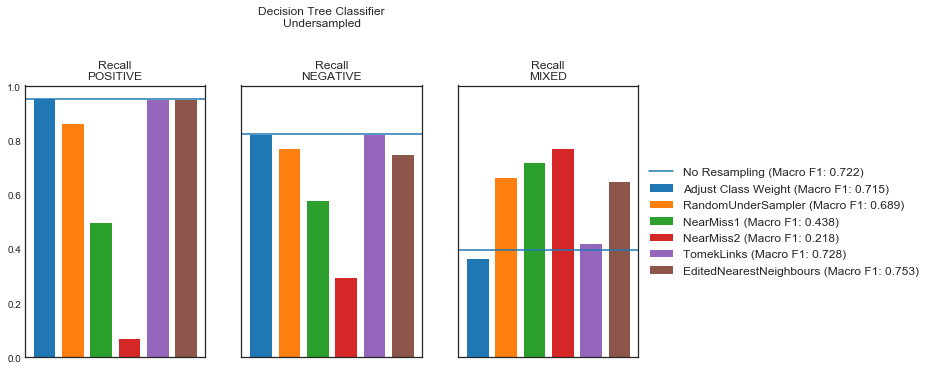

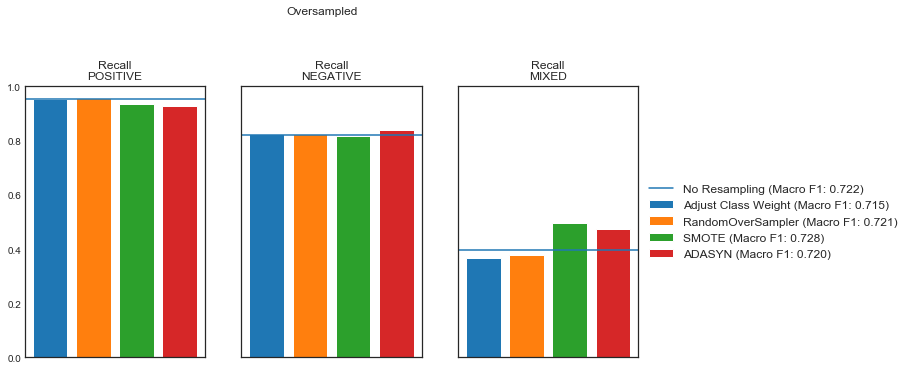

In [44]:
%%time

model = DecisionTreeClassifier()
results_dt_resample = model_resampling_pipeline(X_train, X_val, 
                                                y_train_a, y_val,
                                                model, name = 'Decision Tree Classifier')

In [68]:
# Edited nearest neighbours appeared to acheive the most balance. 
# Nevertheless, recall for the negative and mixed classes was low,
# and precision for the mixed class was especially low.

dt_report = get_report(results_dt_resample, y_val, 
                       'undersample', 'EditedNearestNeighbours')

              precision    recall  f1-score   support

    negative       0.91      0.75      0.83      1866
    positive       0.97      0.95      0.96      8600
       mixed       0.37      0.65      0.47       664

    accuracy                           0.90     11130
   macro avg       0.75      0.78      0.75     11130
weighted avg       0.93      0.90      0.91     11130



<a id="rf"></a>
## Random Forest

Wall time: 4min 9s


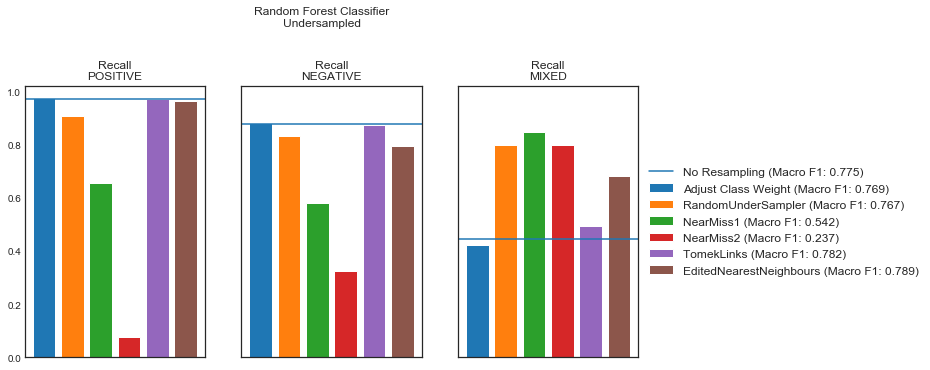

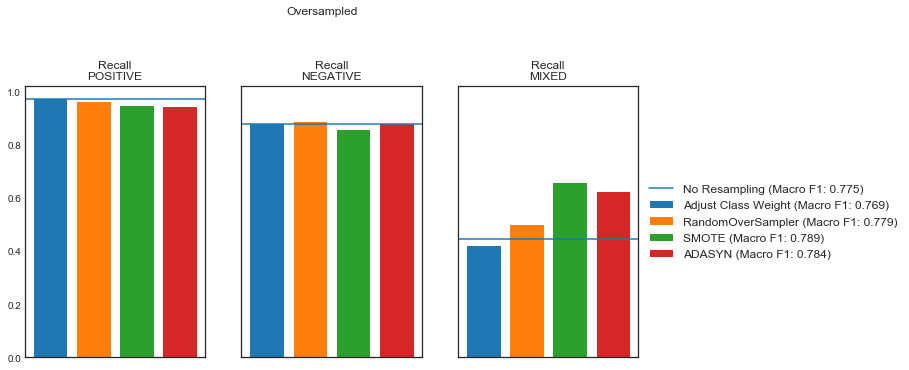

In [45]:
%%time

model = RandomForestClassifier()
results_rf_resample = model_resampling_pipeline(X_train, X_val, 
                                                y_train_a, y_val,
                                                model, name = 'Random Forest Classifier')

In [66]:
# Random Undersampling for Random Forests acheived much better balance
# and performance across classes.

rf_report = get_report(results_rf_resample, y_val, 
                       'undersample', 'RandomUnderSampler')

              precision    recall  f1-score   support

    negative       0.89      0.83      0.86      1866
    positive       0.99      0.91      0.95      8600
       mixed       0.35      0.80      0.49       664

    accuracy                           0.89     11130
   macro avg       0.75      0.85      0.77     11130
weighted avg       0.94      0.89      0.91     11130



Normalized confusion matrix


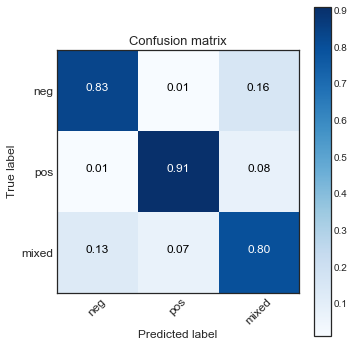

In [67]:
enn_preds = results_rf_resample['undersample']['RandomUnderSampler']['predictions']

cm = confusion_matrix(y_val, enn_preds)
plot_confusion_matrix(cm, ['neg', 'pos', 'mixed'], normalize=True)

<a id="lr"></a>
## Logistic Regression

Wall time: 3min 50s


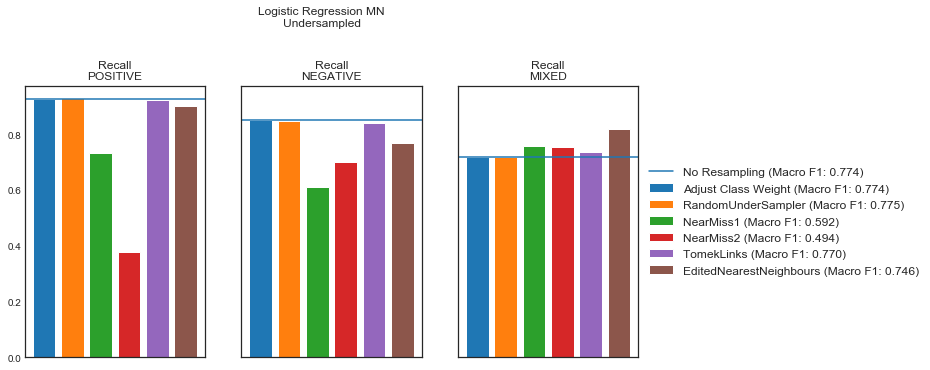

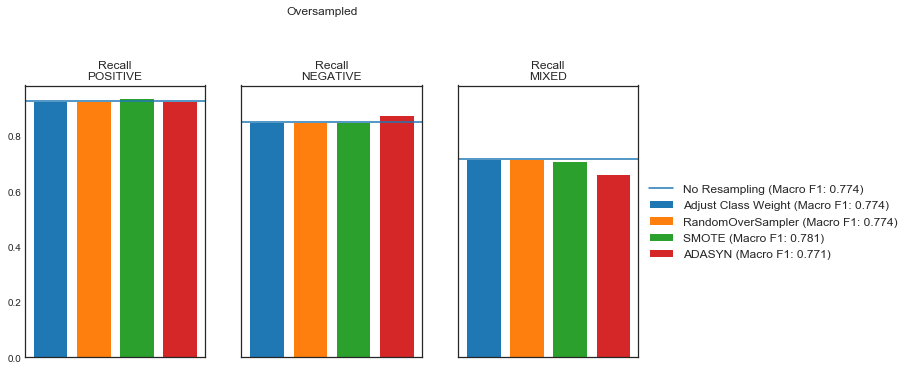

In [46]:
%%time
model = LogisticRegression(solver = 'newton-cg', multi_class='multinomial', 
                           class_weight='balanced')

results_logreg_resample = model_resampling_pipeline(X_train, X_val, 
                                                    y_train_a, y_val,
                                                    model, name = 'Logistic Regression MN')

In [76]:
# Logistic Regression tended to swing towards the negative or mixed class 
# more depending on whether Random Undersampling or class weights were 
# used for balancing.

logreg_report = get_report(results_logreg_resample, y_val, 
                           'class_weight') 

              precision    recall  f1-score   support

    negative       0.87      0.85      0.86      1866
    positive       0.99      0.93      0.96      8600
       mixed       0.39      0.72      0.51       664

    accuracy                           0.90     11130
   macro avg       0.75      0.83      0.77     11130
weighted avg       0.93      0.90      0.91     11130



Normalized confusion matrix


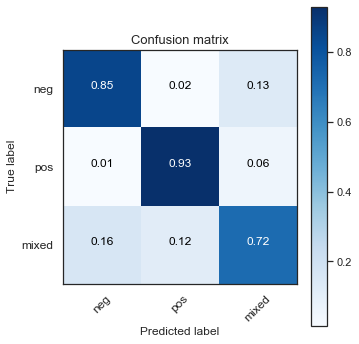

In [77]:
w_preds = results_logreg_resample['class_weight']['predictions']

cm = confusion_matrix(y_val, w_preds)
plot_confusion_matrix(cm, ['neg', 'pos', 'mixed'], normalize=True)

Normalized confusion matrix


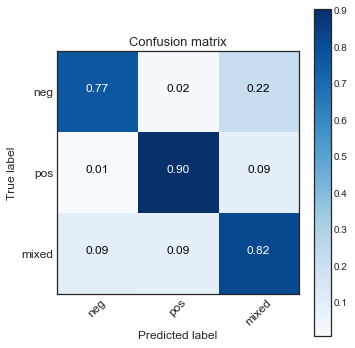

In [63]:
w_preds = results_logreg_resample['undersample']['EditedNearestNeighbours']['predictions']

cm = confusion_matrix(y_val, w_preds)
plot_confusion_matrix(cm, ['neg', 'pos', 'mixed'], normalize=True)

<a id="knn"></a>
## KNN

Wall time: 2min 21s


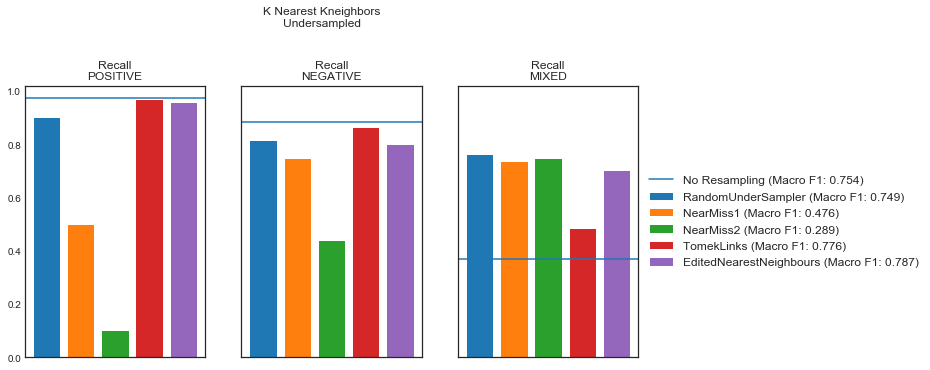

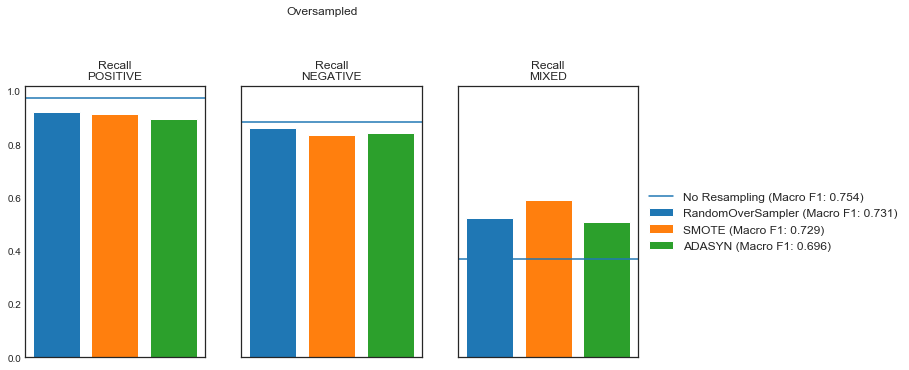

In [47]:
%%time

model = KNeighborsClassifier()
results_knn_resample = model_resampling_pipeline(X_train_z, X_val_z, 
                                                 y_train_a, y_val,
                                                 model, name = 'K Nearest Kneighbors',
                                                 columns = features[:-1])

In [60]:
knn_editednn = get_report(results_knn_resample, y_val,
                          'undersample', 'RandomUnderSampler')

              precision    recall  f1-score   support

    negative       0.86      0.82      0.84      1866
    positive       0.99      0.90      0.94      8600
       mixed       0.34      0.76      0.47       664

    accuracy                           0.88     11130
   macro avg       0.73      0.83      0.75     11130
weighted avg       0.93      0.88      0.90     11130



Normalized confusion matrix


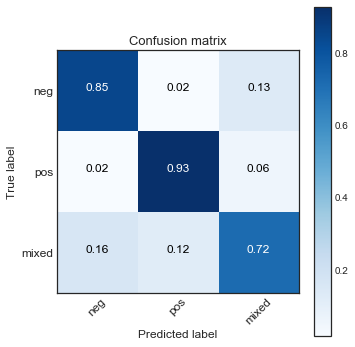

In [61]:
# Performance using KNN was similar to Logistic Regression (class weights)
enn_preds = results_logreg_resample['undersample']['RandomUnderSampler']['predictions']

cm = confusion_matrix(y_val, enn_preds)
plot_confusion_matrix(cm, ['neg', 'pos', 'mixed'], normalize=True)

<a id="ada"></a>
## AdaBoost

Wall time: 2min 11s


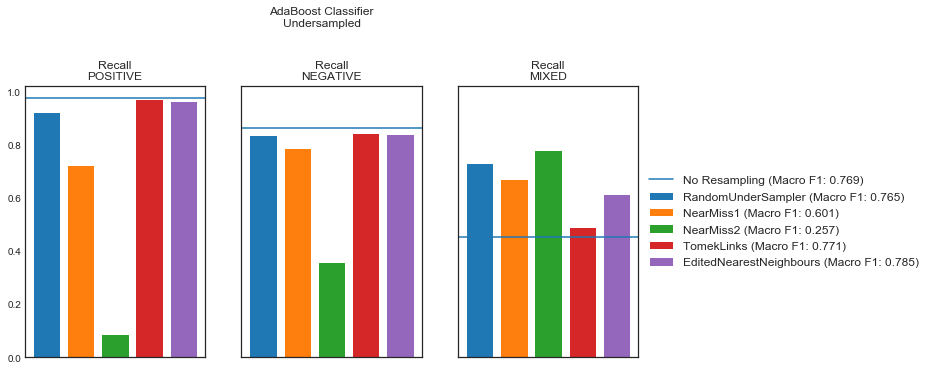

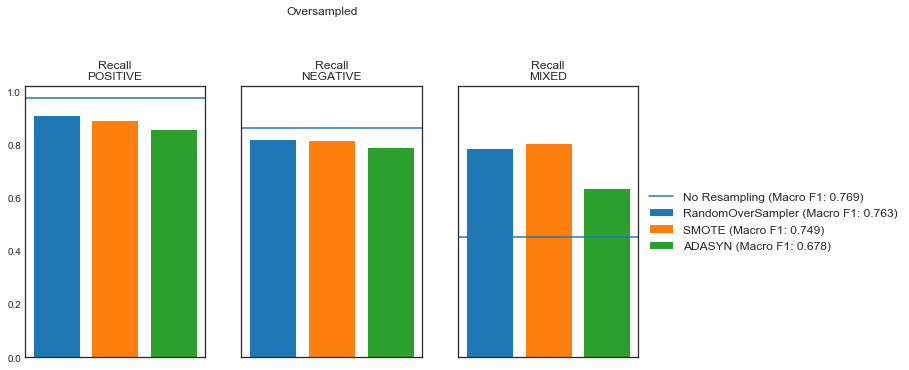

In [48]:
%%time

model = AdaBoostClassifier()
results_ada_resample = model_resampling_pipeline(X_train_z, X_val_z, 
                                                 y_train_a, y_val,
                                                 model, name = 'AdaBoost Classifier',
                                                 columns = features[:-1])

In [59]:
ada_tome = get_report(results_ada_resample, y_val,
                      'undersample', 'RandomUnderSampler')

              precision    recall  f1-score   support

    negative       0.86      0.84      0.85      1866
    positive       0.99      0.92      0.95      8600
       mixed       0.37      0.73      0.49       664

    accuracy                           0.89     11130
   macro avg       0.74      0.83      0.76     11130
weighted avg       0.93      0.89      0.91     11130



<a id="xgb"></a>
## XGBoost

In [49]:
%%time

model = XGBClassifier()
results_xgb_resample = model_resampling_pipeline(X_train, X_val, 
                                                 y_train_a, y_val,
                                                 model, name = 'XGBoost Classifier',
                                                 eval_show=False)

Wall time: 3min 30s


<a id="xgb_w"></a>
## XGBoost Weighted

XGBoost sample weighted solution had to be run outside of the pipeline, as the weights are fitted with an array rather than a parameter setting (as is the case with the previous learners).

The weight array was calculated using this [method.](https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost)

In [50]:
%%time

# Add weighted model
model = XGBClassifier(objective='multi:softmax')
model.fit(X_train, y_train_a, sample_weight=train_a['weights'])
w_predictions = model.predict(X_val)

probas = [x[1] for x in model.predict_proba(X_val)]
scores = metrics.classification_report(y_val, w_predictions, 
                                       target_names=['negative', 'positive', 'mixed'],
                                       output_dict=True)

w_precision = scores.get('weighted avg', {}).get('precision')
w_recall = scores.get('weighted avg', {}).get('recall')
w_fscore = scores.get('weighted avg', {}).get('f1-score')
        
results_xgb_resample['class_weight'] = {'w_precision': w_precision, 'w_recall': w_recall, 
                                        'w_fscore': w_fscore, 'predictions': np.array(w_predictions), 
                                        'probas':probas}


Wall time: 14.2 s


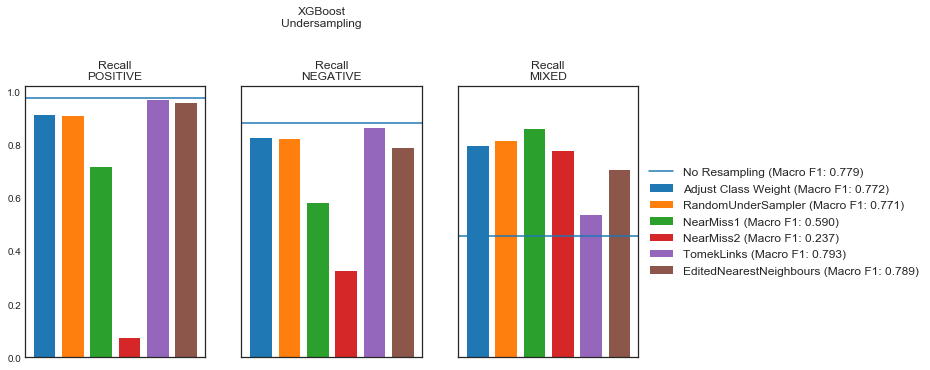

In [51]:
evaluate_method(results_xgb_resample, y_val, 'undersample', title = "XGBoost\nUndersampling")

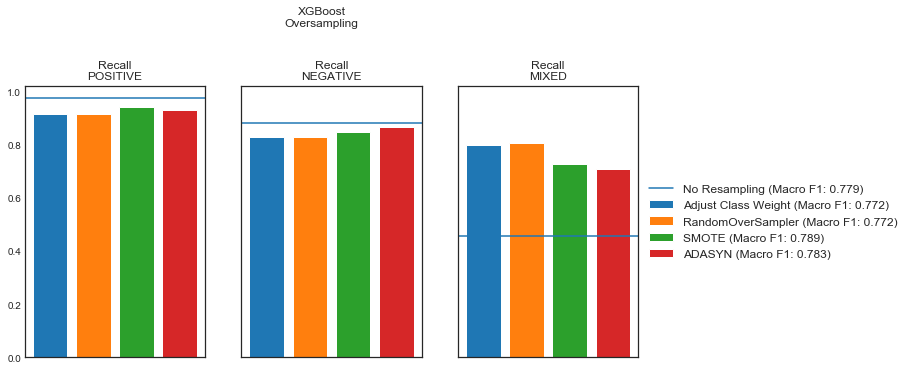

In [52]:
evaluate_method(results_xgb_resample, y_val, 'oversample', title = "XGBoost\nOversampling")

In [58]:
xgb_report = get_report(results_xgb_resample, y_val, 
                        'undersample', 'RandomUnderSampler')

              precision    recall  f1-score   support

    negative       0.89      0.83      0.86      1866
    positive       0.99      0.91      0.95      8600
       mixed       0.36      0.82      0.50       664

    accuracy                           0.89     11130
   macro avg       0.75      0.85      0.77     11130
weighted avg       0.94      0.89      0.91     11130



Normalized confusion matrix


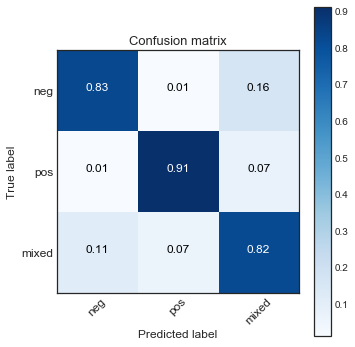

In [54]:
# With XGBoost Random Undersampling resulted in good balance between the classes. 
rus_preds = results_xgb_resample['undersample']['RandomUnderSampler']['predictions']

cm = confusion_matrix(y_val, rus_preds)
plot_confusion_matrix(cm, ['neg', 'pos', 'mixed'], normalize=True)

Normalized confusion matrix


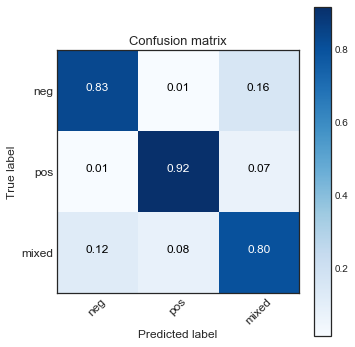

In [55]:
# With class weights working effectively as well. 
cm = confusion_matrix(y_val, w_predictions)
plot_confusion_matrix(cm, ['neg', 'pos', 'mixed'], normalize=True)

The resampling pipeline is exploratory and intended as a baseline. Combining the features and using `RandomUnderSampling` with either an XGBoost or Random Forests classifier appeared to result in the best (most blanaced) performance. XGBoost also produced good results with `Class-weights`.

-----------------------------------------------------
<a id="importance"></a>
# Feature Importance

Feature importance for the class balanced XGBoost is shown below. 

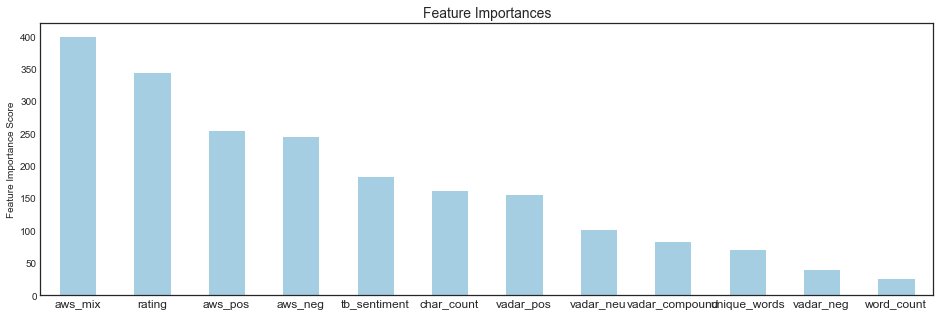

In [57]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
fig = plt.figure(figsize=(16, 5))
feat_imp.plot(kind='bar', colormap='Paired')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importances', fontsize=14)
plt.xticks(np.arange(len(feat_imp)), rotation=0, fontsize=12);

[Return to Index](#index)